In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
import random
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util
import smogn
from smogn.phi import phi
from smogn.phi_ctrl_pts import phi_ctrl_pts
import warnings
from multiprocessing import Pool

In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [4]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,0.2)

In [10]:
X0_tt,scaler0 = util.make_feature_matrix(X_all_c,pre_updrs_off)
X0_t = X0_tt.reshape(X_all_c.shape[0],X_all_c.shape[1],X_all_c.shape[2]+1)

In [15]:
n = 6
def loop(j):
        # Reload training data
        X_in = X0_t[:n,:,:]
        per_change_in = per_change[:n]
        pre_updrs_off_in = pre_updrs_off[:n]
        # Delete test case
        X_in = np.delete(X_in,j,axis=0)
        pre_updrs_off_in = np.delete(pre_updrs_off[:n],j)
        per_change_in = np.delete(per_change[:n],j)
        # Concatenate pre-updrs, scale, and reshape
        X_in_t,scaler = util.make_feature_matrix(X_in,pre_updrs_off_in)
        # Perform SMOGN on training data
        # VERIFY threshold default
        X_in_s,y_in_s,idx_kept,sscaler = util.rad_smogn(X_in_t[:,:-6],per_change_in,
                                                        np.min(per_change_in),
                                                        np.max(per_change_in),
                                                        np.mean(per_change_in),1,0,0.5)
        
        # Rescale synthetic feature matrices and test feature matrix together
        scalerj = StandardScaler()
        X_s = scalerj.fit_transform(np.vstack((X_in_s,X0_t[j,:,:].reshape(X0_t.shape[1]*X0_t.shape[2]))))
        X_test = X_s[-1,:]
        X_train = X_s[:-1,:]
        # Fit
        cvs = KFold(n_splits=X_train.shape[0],shuffle=True)
        reg = LassoCV(max_iter=10000,cv=cvs,eps=0.5,verbose=True).fit(X_in_s,y_in_s)
        # Predict
        #X_test = util.scale_feature_matrix(np.expand_dims(X0_t[j,:,:],axis=0),pre_updrs_off[j],sscaler)
        ut_ls = reg.predict(X_test.reshape(1, -1))
        print('Predicted improvement of ',ut_ls, 'with true improvement', per_change[j])
        return ut_ls
pool = Pool(os.cpu_count())
packet = [*zip(np.arange(n))]
results = pool.map(loop,np.arange(n))

synth_matrix: 100%|##########| 1/1 [00:00<00:00, 5405.03it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.........................................................................................................................................[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..............................................................................................................................[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...........................................[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...........................................................................................................................

In [12]:
# n = 6
# def loop(j):
#         # Reload training data
#         X_in = X0_t[:n,:,:]
#         per_change_in = per_change[:n]
#         pre_updrs_off_in = pre_updrs_off[:n]
#         # Delete test case
#         X_in = np.delete(X_in,j,axis=0)
#         pre_updrs_off_in = np.delete(pre_updrs_off[:n],j)
#         per_change_in = np.delete(per_change[:n],j)
#         # Concatenate pre-updrs, scale, and reshape
#         X_in_t,scaler = util.make_feature_matrix(X_in,pre_updrs_off_in)
#         # Perform SMOGN on training data
#         # VERIFY threshold default
#         X_in_s,y_in_s,idx_kept,sscaler = util.rad_smogn(X_in_t[:,:-6],per_change_in,
#                                                         np.min(per_change_in),
#                                                         np.max(per_change_in),
#                                                         np.mean(per_change_in),1,0,0.5)
#         # Fit
#         cvs = KFold(n_splits=X_in_s.shape[0],shuffle=True)
#         reg = LassoCV(max_iter=10000,cv=cvs,eps=0.5,verbose=True).fit(X_in_s,y_in_s)
#         # Predict
#         X_test = util.scale_feature_matrix(np.expand_dims(X0_t[j,:,:],axis=0),pre_updrs_off[j],scaler)
#         print(X_test.shape)
#         ut_ls = reg.predict(X_test[:-6].reshape(1, -1))
#         print('Predicted improvement of ',ut_ls, 'with true improvement', per_change[j])
#         return ut_ls
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# results = pool.map(loop,np.arange(n))

In [13]:
# n = 6
# ut_ls = np.zeros(n)
# def loop(j):
#         # Reload training data
#         X_in = X0_t[:n,:,:]
#         print(X_in.shape)
#         per_change_in = per_change[:n]
#         pre_updrs_off_in = pre_updrs_off[:n]
#         # Delete test case
#         X_in = np.delete(X_in,j,axis=0)
#         print(X_in.shape)
#         print(j)
#         pre_updrs_off_in = np.delete(pre_updrs_off[:n],j)
#         per_change_in = np.delete(per_change[:n],j)
#         print(pre_updrs_off_in.shape)
#         # Concatenate pre-updrs, scale, and reshape
#         X_in_t,scaler = util.make_feature_matrix(X_in,pre_updrs_off_in)
#         print(X_in_t.shape)
#         # Perform SMOGN on training data
#         # VERIFY threshold default
#         X_in_s,y_in_s,idx_kept,sscaler = util.rad_smogn(X_in_t[:,:-6],per_change_in,
#                                                         np.min(per_change_in),
#                                                         np.max(per_change_in),
#                                                         np.mean(per_change_in),1,0,0.5)
#         # Fit
#         cvs = KFold(n_splits=X_in_s.shape[0],shuffle=True)
#         reg = LassoCV(max_iter=10000,cv=cvs,eps=0.5,verbose=True,n_jobs=-1).fit(X_in_s,y_in_s)
#         # Predict
#         print(X0_t[j,:,:].shape)
#         X_test = util.scale_feature_matrix(np.expand_dims(X0_t[j,:,:],axis=0),pre_updrs_off[j],scaler)
#         print(X_test.shape)
#         ut_ls = reg.predict(X_test[:-6].reshape(1, -1))
#         print('Predicted improvement of ',ut_ls, 'with true improvement', per_change[j])
#         return ut_ls
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# for k in np.arange(n): 
#           ut_ls[k] = loop(k)

<function matplotlib.pyplot.show(*args, **kw)>

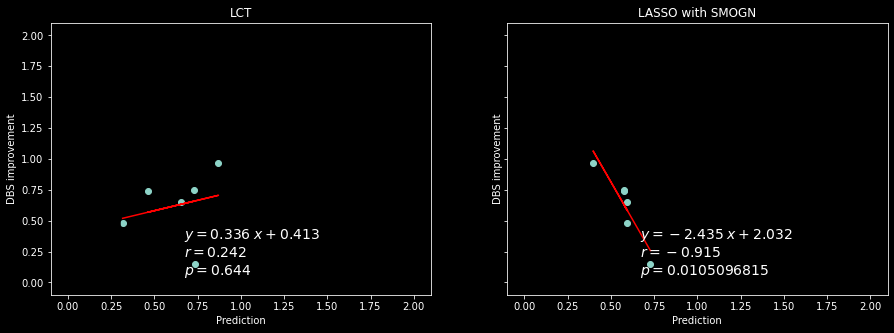

In [14]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
# Cross validation results
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
lr_prepost = linregress(pre_imp[:n],per_change[:n])
ax[0].scatter(pre_imp[:n],per_change[:n],)
ax[0].plot(pre_imp[:n],pre_imp[:n]*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
# ax[0].set_ylim([0, 1])
# ax[0].set_xlim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.35, 0.25, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_qr = linregress(np.asarray(results).ravel(),per_change[:n])
ax[1].scatter(np.asarray(results).ravel(),per_change[:n])
ax[1].plot(np.asarray(results).ravel(),np.asarray(results).ravel()*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[1].set_title('LASSO with SMOGN')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[1].text(0.35, 0.25, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('dark_background')
plt.show